In [50]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave


In [51]:
# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 64
resolution = (64, 64)

# These many images will be used from the data archive
dataset_split = 10000

photos_path = './imagenet/all_kinds'
# photos_path = './imagenet/pomegranate/train'

train_split = 0.8
random_seed = 42


photos = []
for photo_name in os.listdir(photos_path):
    photo = load_img(os.path.join(photos_path, photo_name))
    photo = photo.resize(resolution)
    photo_array = img_to_array(photo)
    photos.append(photo_array)

photos_np = np.array(photos, dtype=float)
photos_np /= 255.0

LAB_images = rgb2lab(photos_np)
X = LAB_images[:, :, :, 0]
y = np.array(photos_np)


train_x, test_x, train_y, test_y = train_test_split(
    X, y, train_size=train_split, random_state=random_seed)

# train_x = train_x.reshape(train_x.shape[0], img_size, img_size, 1)
# test_x = test_x.reshape(test_x.shape[0], img_size, img_size, 1)


# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)


In [52]:
train_x.shape

(8000, 64, 64)

In [53]:

def get_generator_model():

    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 1))

    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1)(inputs)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1)(conv1)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1)(conv2)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)

    bottleneck = tf.keras.layers.Conv2D(128, kernel_size=(
        3, 3), strides=1, activation='relu', padding='same')(conv3)

    concat_1 = tf.keras.layers.Concatenate()([bottleneck, conv3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(
        128, kernel_size=(3, 3), strides=1, activation='relu')(concat_1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(
        128, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_3)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(
        64, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_3)

    concat_2 = tf.keras.layers.Concatenate()([conv_up_3, conv2])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(
        64, kernel_size=(3, 3), strides=1, activation='relu')(concat_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(
        64, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_2)

    concat_3 = tf.keras.layers.Concatenate()([conv_up_2, conv1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(3, 3), strides=1, activation='relu')(concat_3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_1)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(
        3, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_1)

    model = tf.keras.models.Model(inputs, conv_up_1)
    print(model.summary())
    return model


In [54]:

def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) ,padding='same', strides=1 , activation='relu' , input_shape=( img_size, img_size , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) ,padding='same', strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    print(model.summary())
    return model


In [55]:

cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(
        real_output) - tf.random.uniform(shape=real_output.shape, maxval=0.1), real_output)
    fake_loss = cross_entropy(tf.zeros_like(
        fake_output) + tf.random.uniform(shape=fake_output.shape, maxval=0.1), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output, real_y):
    real_y = tf.cast(real_y, 'float32')
    return mse(fake_output, real_y)


generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

generator = get_generator_model()
discriminator = get_discriminator_model()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 60, 60, 16)   416         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_18 (LeakyReLU)      (None, 60, 60, 16)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 58, 58, 32)   4640        leaky_re_lu_18[0][0]             
____________________________________________________________________________________________

In [56]:

@tf.function
def train_step(input_x, real_y):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # print(train_x.shape)
        # Generate an image -> G( x )
        generated_images = generator(input_x, training=True)
        # print('after generator 1')
        # Probability that the given image is real -> D( x )
        # print(f'real y shape {real_y.shape}')
        real_output = discriminator(real_y, training=True)
        # print('after discriminator 1')
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        # print('after discriminator 2')

        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss(generated_images, real_y)
        # Log loss for the discriminator
        disc_loss = discriminator_loss(real_output, generated_output)
        # print('after loss')

    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))


In [57]:
!pip install tqdm
from tqdm import tqdm

In [71]:
epochs = 100
for epoch in range(epochs):
    for (x, y) in tqdm(dataset, desc=f"steps for epoch {epoch}"):
        train_step(x, y)

steps for epoch 99: 100%|██████████| 125/125 [00:41<00:00,  3.02it/s]


In [ ]:
generator.save_weights(f"gan_generator_imagenet_{epochs}.h5")
discriminator.save_weights(f"gan_discriminator_imagenet_{epochs}.h5")

In [94]:
# generate all test images
generated_y = []
batch_size = 50
for batch in range(batch_size, len(test_x)+batch_size, batch_size):
    batched_x = test_x[batch - batch_size: batch]
    batched_y = generator(np.asarray(batched_x)).numpy()
    generated_y.extend(batched_y)

# get original images
original_y = np.asarray(test_y)

len(original_y), len(generated_y)

(2000, 2000)

In [90]:
! pip install image-similarity-measures
from image_similarity_measures.quality_metrics import rmse, psnr, ssim, fsim, uiq

     ---------------------------------------- 22.2/22.2 MB 5.0 MB/s eta 0:00:00
     ---------------------------------------- 35.6/35.6 MB 5.2 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26966 sha256=de8193db3942b182ae7a270d957a73a2615d0810458e0d4d08a4e24d16c0926d
  Stored in directory: c:\users\soham\appdata\local\pip\cache\wheels\a0\cd\22\acdeec70f562ae574ad93d9b3254922dddc630e987f6e3c4ff
Successfully built phasepack


In [102]:
from numba import jit, cuda
import pandas as pd

@jit(target_backend='cuda')
def get_all_images(generated_y, original_y):
    all_images = {
        'original':[],
        'generated':[],
        'rmse':[],
        'psnr':[],
        'fsim':[],
        'uiq':[],
    }

    for generated, original in tqdm(zip(generated_y, original_y)):
        og_img = np.array(original)
        og_img = 1.0 / 255 *np.asarray(og_img)
        col_img = np.array(generated)
        col_img = 1.0 / 255 *np.asarray(col_img)

        img_rmse = rmse(og_img, col_img)
        img_psnr = psnr(og_img, col_img)
        img_fsim = fsim(og_img, col_img)
        img_uiq = uiq(og_img, col_img)
        # img_rmse, img_psnr, img_fsim, img_uiq = get_image_metrics(og_img, col_img)
        all_images['original'].append(original)
        all_images['generated'].append(generated)
        all_images['rmse'].append(img_rmse)
        all_images['psnr'].append(img_psnr)
        all_images['fsim'].append(img_fsim)
        all_images['uiq'].append(img_uiq)
    return all_images

all_images = get_all_images(generated_y, original_y)

df = pd.DataFrame(all_images)
df.head()

C:\Users\Soham\AppData\Local\Temp\ipykernel_22608\1489898061.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_all_images" failed type inference due to: Untyped global name 'tqdm': Cannot determine Numba type of <class 'type'>

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_22608\1489898061.py", line 15:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
C:\Users\Soham\AppData\Local\Temp\ipykernel_22608\1489898061.py:4: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_all_images" failed type inference due to: Untyped global name 'tqdm': Cannot determine Numba type of <class 'type'>

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_22608\1489898061.py", line 15:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
d:\ProgramData\Anaconda3\envs\kewlar\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "

original  \
0  [[[0.06274509803921569, 0.0784313725490196, 0....   
1  [[[0.5137254901960784, 0.41568627450980394, 0....   
2  [[[0.3607843137254902, 0.403921568627451, 0.42...   
3  [[[0.39215686274509803, 0.3686274509803922, 0....   
4  [[[0.807843137254902, 0.6980392156862745, 0.55...   

                                           generated          rmse  \
0  [[[0.21797939, 0.19623034, 0.20296253], [0.150...  8.099337e-08   
1  [[[0.41259503, 0.3837749, 0.34950396], [0.4768...  5.486831e-08   
2  [[[0.31048614, 0.27755833, 0.23804952], [0.327...  6.542236e-08   
3  [[[0.46774587, 0.44026196, 0.4007804], [0.5101...  6.661422e-08   
4  [[[0.6527038, 0.62319624, 0.5575974], [0.69003...  7.613668e-08   

         psnr      fsim       uiq  
0  141.831012  0.980475  0.872516  
1  145.213571  0.993195  0.875569  
2  143.685479  0.991386  0.940206  
3  143.528662  0.989594  0.937743  
4  142.368121  0.986120  0.815049

In [103]:
df.to_csv(open('test_imagenet_metrics.csv', 'wb'))

In [105]:
uiq_df = df.sort_values(by='uiq', ascending=False)
uiq_df.head()

original  \
1293  [[[0.6980392156862745, 0.6980392156862745, 0.7...   
644   [[[0.34509803921568627, 0.403921568627451, 0.3...   
1663  [[[0.6196078431372549, 0.5254901960784314, 0.4...   
1521  [[[0.2, 0.15294117647058825, 0.098039215686274...   
1587  [[[0.8901960784313725, 0.7450980392156863, 0.6...   

                                              generated          rmse  \
1293  [[[0.6623294, 0.66158146, 0.6436583], [0.72175...  4.757312e-08   
644   [[[0.3298764, 0.36283314, 0.43568775], [0.3382...  4.517560e-08   
1663  [[[0.5069926, 0.48073754, 0.43542856], [0.6627...  3.749565e-08   
1521  [[[0.14274274, 0.11079867, 0.102582976], [0.14...  3.260610e-08   
1587  [[[0.65459484, 0.648413, 0.6023843], [0.675129...  4.768207e-08   

            psnr      fsim       uiq  
1293  146.452765  0.997662  0.987133  
644   146.901922  0.995864  0.983562  
1663  148.520384  0.998434  0.983377  
1521  149.734025  0.996052  0.982211  
1587  146.432896  0.995930  0.981945

In [106]:
rmse_df = df.sort_values(by='rmse', ascending=False)
rmse_df.head()

original  \
1869  [[[0.0196078431372549, 0.15294117647058825, 0....   
1911  [[[0.023529411764705882, 0.0, 0.03921568627450...   
1623  [[[0.0392156862745098, 0.5647058823529412, 0.9...   
1620  [[[0.00392156862745098, 0.2627450980392157, 0....   
271   [[[0.00784313725490196, 0.29411764705882354, 0...   

                                              generated          rmse  \
1869  [[[0.3091951, 0.2772165, 0.25233188], [0.32045...  4.024730e-07   
1911  [[[0.05884352, 0.023895219, 0.02481326], [0.05...  3.880033e-07   
1623  [[[0.46592596, 0.5039712, 0.57608664], [0.4639...  3.856519e-07   
1620  [[[0.33139533, 0.30283764, 0.28216174], [0.356...  3.576805e-07   
271   [[[0.21416791, 0.17280126, 0.14577645], [0.235...  3.388268e-07   

            psnr      fsim       uiq  
1869  127.905264  0.884654  0.346723  
1911  128.223290  0.942163  0.524216  
1623  128.276091  0.885637  0.376224  
1620  128.930097  0.829245  0.399282  
271   129.400444  0.944618  0.304269

In [107]:
all_sorted_df = df.sort_values(by=['uiq', 'fsim', 'psnr', 'rmse'], ascending=False)
all_sorted_df.head()

original  \
1293  [[[0.6980392156862745, 0.6980392156862745, 0.7...   
644   [[[0.34509803921568627, 0.403921568627451, 0.3...   
1663  [[[0.6196078431372549, 0.5254901960784314, 0.4...   
1521  [[[0.2, 0.15294117647058825, 0.098039215686274...   
1587  [[[0.8901960784313725, 0.7450980392156863, 0.6...   

                                              generated          rmse  \
1293  [[[0.6623294, 0.66158146, 0.6436583], [0.72175...  4.757312e-08   
644   [[[0.3298764, 0.36283314, 0.43568775], [0.3382...  4.517560e-08   
1663  [[[0.5069926, 0.48073754, 0.43542856], [0.6627...  3.749565e-08   
1521  [[[0.14274274, 0.11079867, 0.102582976], [0.14...  3.260610e-08   
1587  [[[0.65459484, 0.648413, 0.6023843], [0.675129...  4.768207e-08   

            psnr      fsim       uiq  
1293  146.452765  0.997662  0.987133  
644   146.901922  0.995864  0.983562  
1663  148.520384  0.998434  0.983377  
1521  149.734025  0.996052  0.982211  
1587  146.432896  0.995930  0.981945

1293
644
1663
1521
1587


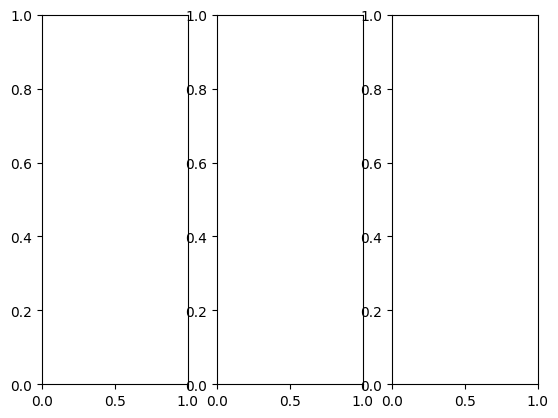

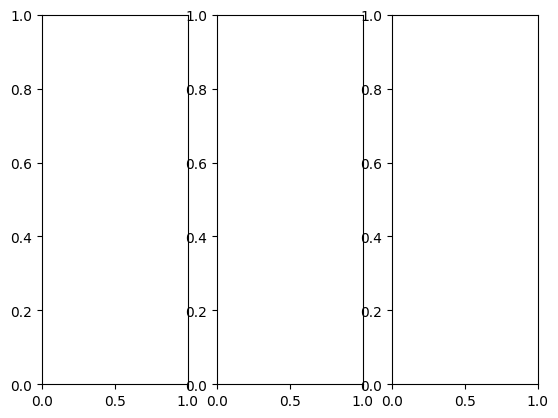

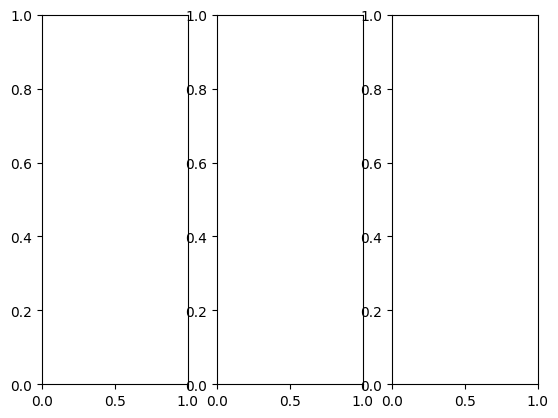

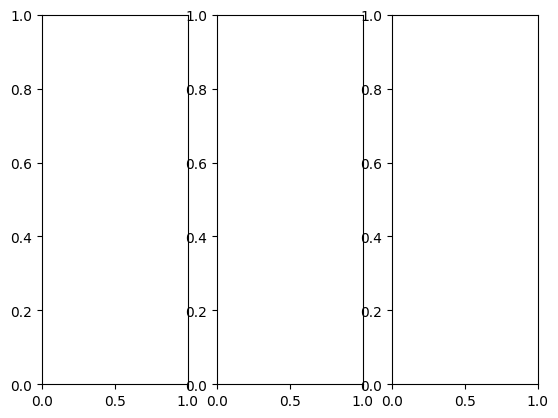

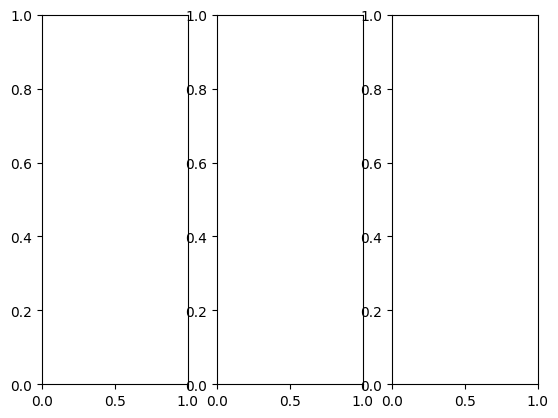

In [121]:
render_resolution = (128, 128)
import matplotlib.pyplot as plt
import random

for i, row in all_sorted_df[:5].iterrows():
    print(row.name)
    f, axarr = plt.subplots(1,3)
    colorized = Image.fromarray((row['generated'] * 255).astype('uint8')).resize(render_resolution)
    # colorized = np.asarray(colorized)
    original = Image.fromarray((row['original'] * 255).astype('uint8')).resize(render_resolution)
    greyscale = Image.fromarray((test_x[int(row.name)]).astype('uint8')).resize(render_resolution)
    # axarr[0].imshow(original)
    # axarr[1].imshow(colorized)
    # axarr[2].imshow(np.asarray(greyscale), cmap='gray')
    original.save(f'original_{row.name}.jpeg')
    colorized.save(f'colorized_{row.name}.jpeg')
    greyscale.save(f'greyscale_{row.name}.jpeg')


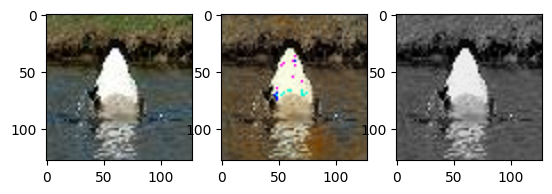

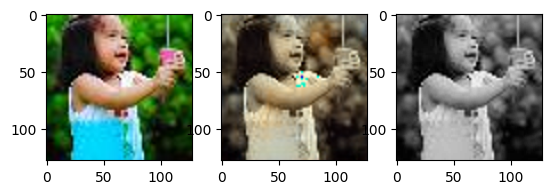

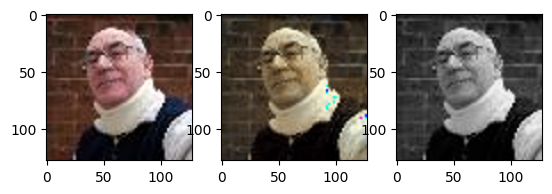

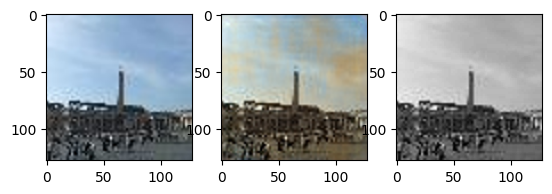

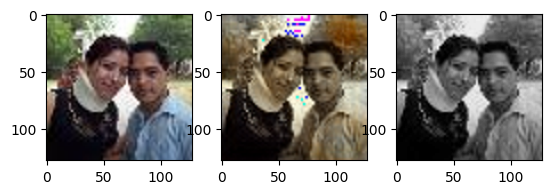

In [79]:
render_resolution = (128, 128)
import matplotlib.pyplot as plt
import random

sample_lenght = 5
samples = random.sample(range(len(test_x)),sample_lenght)

y = generator(np.array(test_x)[samples]).numpy()

# y = generator(test_x[0: 25]).numpy()
# samples = random.sample(range(25), 3 )
for i, sample in enumerate(samples):
    f, axarr = plt.subplots(1,3)
    colorized = Image.fromarray((y[i] * 255).astype('uint8')).resize(render_resolution)
    colorized = np.asarray(colorized)
    original = Image.fromarray((test_y[sample] * 255).astype('uint8')).resize(render_resolution)
    grayscale = Image.fromarray((test_x[sample] ).astype('uint8')).resize(render_resolution)
    axarr[0].imshow(original)
    axarr[1].imshow(colorized)
    axarr[2].imshow(np.asarray(grayscale), cmap='gray')
